<a href="https://colab.research.google.com/github/OgulcanErd/Hesap-makinesi/blob/master/Cloths_segmentation_CID.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installing Helper Functions

In [1]:
!pip install iglovikov_helper_functions

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.5/64.5 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 26.8 MB/s eta 0:00:00
  Created wheel for jpeg4py: filename=jpeg4py-0.1.4-py3-none-any.whl size=8422 sha256=9f7d90bad7ffb3b91f8818d2c8ccccb37c8b0686d470fe434912e7f7d3b1d3a2
  Stored in directory: /root/.cache/pip/wheels/86/c3/0f/348e6cadb3a27435e833d21d91707d653fb159d69f2a867a36
Successfully built jpeg4py


In [2]:
!wget https://habrastorage.org/webt/em/l7/cr/eml7crxnxftrimsmolwjegqcrp4.jpeg > /dev/null

--2024-11-28 12:47:54--  https://habrastorage.org/webt/em/l7/cr/eml7crxnxftrimsmolwjegqcrp4.jpeg
Resolving habrastorage.org (habrastorage.org)... 45.120.177.159, 2a01:4f9:3b:48e8::4115:7879, 2a01:4f9:4a:2897::5fd9:6b0c
Connecting to habrastorage.org (habrastorage.org)|45.120.177.159|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 55211 (54K) [image/jpeg]
Saving to: ‘eml7crxnxftrimsmolwjegqcrp4.jpeg’

eml7crxnxftrimsmolw 100%[===================>]  53.92K  --.-KB/s    in 0.1s    

2024-11-28 12:47:55 (552 KB/s) - ‘eml7crxnxftrimsmolwjegqcrp4.jpeg’ saved [55211/55211]



Installing cloth segmentation module from pypi

In [3]:
!pip install cloths_segmentation  > /dev/null

In [4]:
%matplotlib inline

Importing necessary modules

In [5]:
import numpy as np

In [6]:
import cv2

In [7]:
import torch

In [8]:
import albumentations as albu

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [10]:
from pylab import imshow

In [11]:
#trying to save on google drive, so, mounting it to my google drive
from google.colab import drive
drive.mount('/content/gdrive') # connects Colab to your Google Drive

Mounted at /content/gdrive


If you want to use cloth segmentation on images from gallary, run below code

In [18]:

from google.colab import files
img = files.upload()
keys = list(img) # list of all image names from dictionary of images uploaded
allowefileformats = ['jpg','png','bmp','jpeg']
if len(img)!=1:
  print('Please Select only one image file')

elif keys[0].split('.')[-1] not in allowefileformats:
  print('Please select an image in formats: ',allowefileformats)

img_data = img[keys[-1]]
img_path = 'gdrive/My Drive/Colab Notebooks/Cloth_Segmentation_Project/cloths segs data'+keys[-1] # set root path to folder where you uploaded the data
with open(img_path,'wb') as f:
  f.write(img_data)
#image = load_rgb(img_path) #if this line will be uncommented, comment out below three lines

#from PIL import Image
#from io import BytesIO
#image = Image.open(BytesIO(img[keys[0]]))#----- this is related to below line

Saving Ekran görüntüsü 2024-11-27 114636.png to Ekran görüntüsü 2024-11-27 114636.png


Program to open web camera in google colab and take picture.

If you want to use cloth segmentation on webcam captured image, run below code

In [19]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  img_path = 'gdrive/My Drive/Colab Notebooks/Cloth_Segmentation_Project/cloths segs data/'+filename # set root path to folder where you uploaded the data
  with open(img_path, 'wb') as f:
    f.write(binary)
  return img_path

Calling Above function to run and capture the photo.

<IPython.core.display.Javascript object>

Saved to gdrive/My Drive/Colab Notebooks/Cloth_Segmentation_Project/cloths segs data/photo.jpg


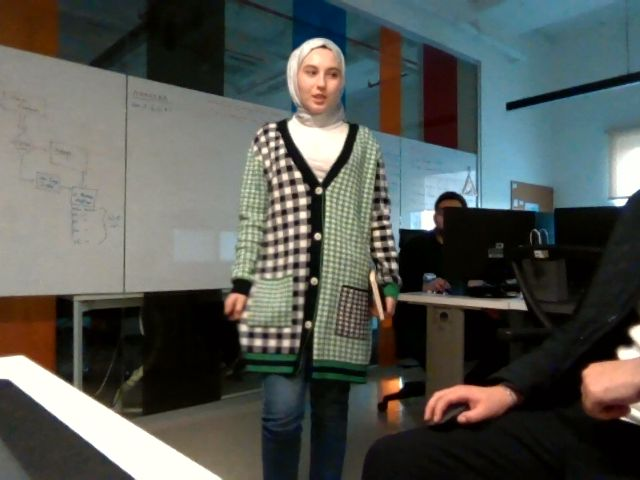

In [77]:
from IPython.display import Image
try:
  img_path = take_photo()
  print('Saved to {}'.format(img_path))

  # Show the image which was just taken.
  display(Image(img_path))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

Importing Important things from helper functions

In [79]:
from iglovikov_helper_functions.utils.image_utils import load_rgb, pad, unpad
from iglovikov_helper_functions.dl.pytorch.utils import tensor_from_rgb_image

In [80]:
from cloths_segmentation.pre_trained_models import create_model

In [81]:
model = create_model("Unet_2020-10-30")

In [82]:
model.eval();

In [83]:
image = load_rgb(img_path)

In [84]:
#print(img)
print(img)

#files.view(keys[-1])
#image = np.array(image)

{'Ekran görüntüsü 2024-11-27 114636.png': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01\xd6\x00\x00\x02\x84\x08\x06\x00\x00\x00\xba\xb4\x1b;\x00\x00\x00\x01sRGB\x00\xae\xce\x1c\xe9\x00\x00\x00\x04gAMA\x00\x00\xb1\x8f\x0b\xfca\x05\x00\x00\x00\tpHYs\x00\x00\x0e\xc3\x00\x00\x0e\xc3\x01\xc7o\xa8d\x00\x00\xff\xa5IDATx^\xec\xfd\x7f\x8c^\xd9y\xdf\t\xde\x96H\xb9J"\xe3\xaa\xa8\xb9\xae\xb2\xc4\xf1\x963\xadL1\xd3\x8d\xb0f\xd4\x9b\xe6Nz\x16\xf4B\x06\xd8X\x1b\xe8\xc6\xc6\x80\x1a\x88\x17h\x03\x0e\xa0\x00\xb3\x18\x0b\xd8\x01b`\xf3\x87\x02d\x00\t3\x03\xa8\x81\x18p\x03\xeb`Z\x80\r\xb0\x81\x18\x10\x17\x11\x10bV\x1e\xb0g\xbawX\x13q\xc3B\xcc$e\x87mW\xd9d\\\x157G,K\x94\xb4\xdf\xcf\xf7<\xcfy\xcf\xbd\xef}\xeb\x07\x9b\xecf\xb7\xf8\xad:\xef=\xf7\xfcx\xces\x9e\xf3\xe39\xe7\xdcs\xcf}b\xe1\xc9\x85\x1fu\xfb\xe0\xf5\xdfz=l\xf7\x8f\xcd\xcd\xcd\xee\xef\xfe\xdd\xbf\xdb\x9d\xff\xc2\xf9\xee\xd7\xfe\x8b_\xeb\xdex\xe3\x8d\xee\xb5\xd7^\xeb\xbe\xfe\x8f\xbe\xde\xad\x9c^\x89P\xd3\xd8\xd8\xd8\xe8\xbe\xfc\xe5/w_\xfa\xd2\x97

In [ ]:
#trying to
#imshow(image)
#files.download('pankaj.png')
imshow(image)

In [86]:
transform = albu.Compose([albu.Normalize(p=1)], p=1)

In [87]:
padded_image, pads = pad(image, factor=32, border=cv2.BORDER_CONSTANT)

In [88]:
x = transform(image=padded_image)["image"]
x = torch.unsqueeze(tensor_from_rgb_image(x), 0)

In [89]:
with torch.no_grad():
  prediction = model(x)[0][0]

In [90]:
mask = (prediction > 0).cpu().numpy().astype(np.uint8)

In [91]:
mask = unpad(mask, pads)

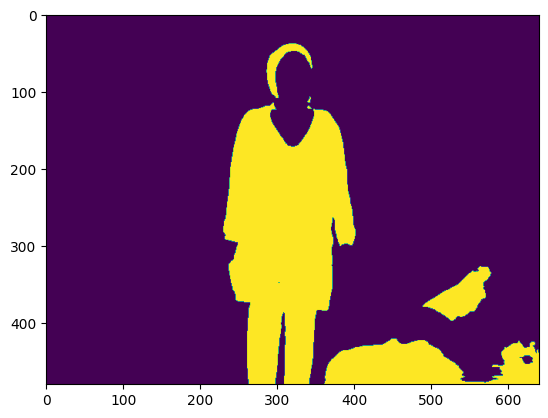

In [92]:
imshow(mask)

In [93]:
dst = cv2.addWeighted(image, 1, (cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB) * (0, 255, 0)).astype(np.uint8), 0.5, 0)

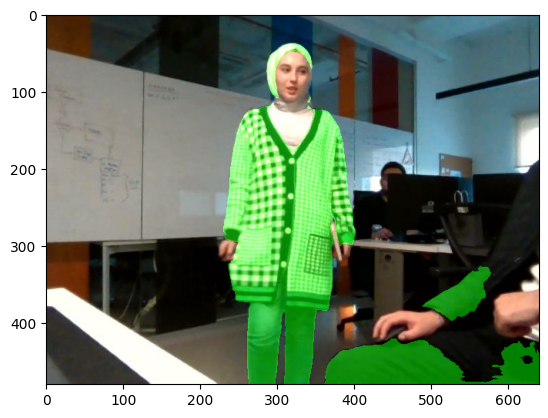

In [94]:
imshow(dst)

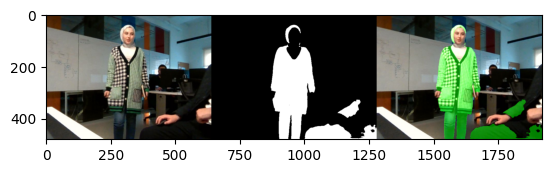

In [95]:
imshow(np.hstack([image, cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB) * 255, dst]))